In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

import wandb
import os

from sklearn.decomposition import PCA

import GPUtil

# Loading Data:
---

In [2]:
file_path = '../data/test_data.csv'
data = pd.read_csv(file_path)
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

In [ ]:
data.head()

,Unnamed: 0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,298520,1364474,28.0,27.0,26.0,24.0,22.0,22.0,20.0,20.0,...,6.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,77906,477962,96.0,99.0,103.0,105.0,108.0,111.0,113.0,117.0,...,-14.0,DEM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,149391,843445,87.0,87.0,86.0,86.0,86.0,87.0,89.0,92.0,...,-14.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,262066,1262888,97.0,100.0,104.0,106.0,111.0,115.0,118.0,124.0,...,-3.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,279662,1321891,122.0,128.0,133.0,140.0,146.0,153.0,159.0,169.0,...,-4.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
data.columns[-8:]

Index(['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO'], dtype='object')

In [5]:
name_smiles_embedding_df.head()

,Unnamed: 0,Name,SMILES,embedding
0,BKG,background,NaN,NaN
1,DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
2,DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
3,MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
4,DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [6]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [7]:
name_smiles_embedding_df['SMILES']['DEM']

# name_smiles_embedding_df.head()

'CCOC(=O)CC(=O)OCC'

# Definitions:
---

In [20]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      # nn.Linear(1676,1300),
      # nn.LeakyReLU(inplace=True),
      # nn.Linear(1300,1000),
      # nn.LeakyReLU(inplace=True),
      # nn.Linear(1000,700),
      # nn.LeakyReLU(inplace=True),
      # nn.Linear(700,512),
      nn.Linear(1676,1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548,1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [9]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [10]:
def plot_emb_pca(all_embeddings, all_chemical_names, output_embeddings, output_labels):
    """
    Run pca on embeddings from denoiser output. Plot results against PCA of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    """

    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    # Extract true embeddings for all chemicals and transform them using the fitted PCA
    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]
    true_transformed = pca.transform(true_embeddings)

    # Transform the encoder output embeddings using the same PCA
    output_embeddings = np.array([emb.detach().numpy() for emb in output_embeddings])
    output_transformed = pca.transform(np.array(output_embeddings))

    # Create a color map where each chemical name is assigned a unique integer
    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map chemical names to their respective colors for the true embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    # Map chemical names to their respective colors for the output embeddings
    output_colors = [color_map[chem] for chem in output_labels]

    # Extract the x and y coordinates from the transformed true embeddings
    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    # Extract the x and y coordinates from the transformed true embeddings
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    # Extract the x and y coordinates from the transformed output embeddings
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    # Create a scatter plot for the output embeddings
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    # Add a legend to the plot
    plt.legend(handles=scatter.legend_elements()[0],
                labels=all_chemical_names,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Denoiser Output')
    plt.xticks([])
    plt.yticks([])

    plt.show()

# Creating Dataloader Objects
---

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


Currently embeddings are strings instead of a list of floats. Would be good to fix that in preprocessing.

In [13]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

In [14]:
# drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
train_spectra = data.iloc[:,2:-9]
train_chem_encodings = data.iloc[:,-8:]

In [15]:
train_chem_labels = list(data['Label'])
train_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in train_chem_labels])#.to(device)
train_spectra_tensor = torch.Tensor(train_spectra.values)#.to(device)
train_chem_encodings_tensor = torch.Tensor(train_chem_encodings.values)#.to(device)

batch_size = 128
train_dataset = DataLoader(TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_embeddings_tensor), batch_size=batch_size, shuffle=True)

# Train Encoder:
---

In [16]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/models/ims_encoder.ipynb'

In [17]:
# Get the allocated memory on the GPU
allocated_memory = torch.cuda.memory_allocated(device) / (1024 ** 2)  # in MB
cached_memory = torch.cuda.memory_reserved(device) / (1024 ** 2)  # in MB

print(f"Allocated Memory: {allocated_memory:.2f} MB")
print(f"Cached Memory: {cached_memory:.2f} MB")

Allocated Memory: 0.00 MB
Cached Memory: 0.00 MB


In [18]:
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU ID: {gpu.id}, Memory Free: {gpu.memoryFree}MB, Memory Used: {gpu.memoryUsed}MB, Memory Total: {gpu.memoryTotal}MB")

GPU ID: 0, Memory Free: 2674.0MB, Memory Used: 21542.0MB, Memory Total: 24564.0MB
GPU ID: 1, Memory Free: 24203.0MB, Memory Used: 14.0MB, Memory Total: 24564.0MB


In [ ]:
# These two should be the same
sorted_chem_names = list(data.columns[-8:])
# sorted_chem_names = ['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO']

epochs = 20
learning_rate = .00001
encoder = Encoder().to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = learning_rate)
encoder_criterion = nn.MSELoss()

predicted_embeddings = []
output_chem_names = []
output_name_encodings = []

wandb_kwargs = {
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'model_architecture': 'encoder',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
}

run_with_wandb(config, **wandb_kwargs)

for epoch in range(epochs):
  # accumulate epoch loss
  epoch_training_loss = 0
  gpus = GPUtil.getGPUs()
  # for gpu in gpus:
  #     print(f"GPU ID: {gpu.id}, percent of total memory used: {round(gpu.memoryUsed/gpu.memoryTotal, 2)}%")

  for batch, name_encodings, true_embeddings in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # forward pass
    batch_predicted_embeddings = encoder(batch)

    loss = encoder_criterion(batch_predicted_embeddings, true_embeddings)
    epoch_training_loss += loss.item()

    # backprapogation
    encoder_optimizer.zero_grad()
    loss.backward()
    encoder_optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == epochs:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  average_loss = epoch_training_loss/len(train_dataset)
  wandb.log({"Encoder Training Loss": average_loss})

  if (epoch + 1) % 1 == 0:
    print('Epoch[{}/{}], loss: {}'.format(epoch+1, epochs, average_loss))
    print('-------------------------------------------')

wandb.finish()


  # # NEEDS to be updated for gpu
  # encoder.eval() # Set model to evaluation mode
  # epoch_val_loss = 0
  # with torch.no_grad():
  #   for batch, name_encodings, true_embeddings in val_dataset:
  #     batch_predicted_embeddings = encoder(batch)

  #     loss = encoder_criterion(batch_predicted_embeddings, true_embeddings)
  #     epoch_test_loss += loss.item()

  # # Set models back to training mode
  # encoder.train()
  # val_average_loss = epoch_test_loss/len(val_dataset)
  # wandb.log({"Encoder Validation Loss": val_average_loss})
  # wandb.log({"Encoder Validation Loss": val_average_loss})
  # print('Test loss: {:.4f}'.format(test_average_loss))

Using device: cuda
Epoch[1/20], loss: 2.571759672138859e-05
-------------------------------------------
Epoch[2/20], loss: 1.64813366511445e-05
-------------------------------------------
Epoch[3/20], loss: 1.367245242778969e-05
-------------------------------------------
Epoch[4/20], loss: 1.10943284355393e-05
-------------------------------------------
Epoch[5/20], loss: 8.745523214672395e-06
-------------------------------------------


In [23]:
# Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
predicted_embeddings_flattened = [emb.cpu() for emb_list in predicted_embeddings for emb in emb_list]
chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]
# Get chemical names from encodings
chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

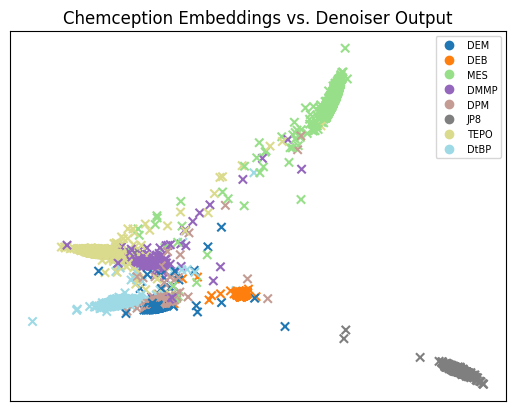

In [24]:
# making list of all embeddings and chem names except for BKG
embeddings = [emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]
cols = name_smiles_embedding_df.index[1:]
true_embeddings = pd.DataFrame(embeddings).T
true_embeddings.columns = cols
true_embeddings.columns

plot_emb_pca(true_embeddings, list(name_smiles_embedding_df.index)[1:], predicted_embeddings_flattened, chem_names)

In [ ]:
# Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
predicted_embeddings_flattened = [emb.cpu() for emb_list in predicted_embeddings for emb in emb_list]
chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]
# Get chemical names from encodings
chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

# making list of all embeddings and chem names except for BKG
embeddings = [emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]
cols = name_smiles_embedding_df.index[1:]
true_embeddings = pd.DataFrame(embeddings).T
true_embeddings.columns = cols
true_embeddings.columns

plot_emb_pca(true_embeddings, list(name_smiles_embedding_df.index)[1:], predicted_embeddings_flattened, chem_names)